# Word Embeddings Model for Twitter Sentiment Analysis

Word embeddings using pre-trained word embeddings from GloVe

Using lemmatization

# Imports and Constants

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer
import evaluation_functions
from sklearn.feature_extraction.text import TfidfTransformer 
from imblearn.over_sampling import SMOTE
import ast
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping
from nltk.stem import WordNetLemmatizer
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functio

In [2]:
DATA_FILE_PATH = '../data/crowdflower-brands-and-product-emotions/data/'
TOKENIZED_DATA_FILE_NAME = 'tokenized_twitter_data.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42
# glove file originaly downloaded from https://nlp.stanford.edu/projects/glove/
GLOVE_FILE_PATH = '../data/glove.twitter.27B/'
GLOVE_FILE_NAME = 'glove.twitter.27B.100d.txt'
MODEL_FILE_PATH = '../models/emb_model_05/'
MODEL_FILE_NAME = 'emb_model_04-lemma'+'best_model.h5'

# Load Data

In [3]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [4]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tokens
0,i have a g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw,iPhone,Negative emotion,"['i', 'have', 'a', 'g', 'iphone', 'after', 'hrs', 'tweeting', 'at', '#riseaustin', 'it', 'was', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', '#sxsw']"
1,know about awesome ipad/iphone app that you'll likely appreciate for its design also they're giving free ts at #sxsw,iPad or iPhone App,Positive emotion,"['know', 'about', 'awesome', 'ipad', 'iphone', 'app', 'that', ""you'll"", 'likely', 'appreciate', 'for', 'its', 'design', 'also', ""they're"", 'giving', 'free', 'ts', 'at', '#sxsw']"
2,can not wait for #ipad also they should sale them down at #sxsw,iPad,Positive emotion,"['can', 'not', 'wait', 'for', '#ipad', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', '#sxsw']"
3,i hope this year's festival isn't as crashy as this year's iphone app #sxsw,iPad or iPhone App,Negative emotion,"['i', 'hope', 'this', ""year's"", 'festival', ""isn't"", 'as', 'crashy', 'as', 'this', ""year's"", 'iphone', 'app', '#sxsw']"
4,great stuff on fri #sxsw: marissa mayer (google) tim o'reilly (tech books/conferences) matt mullenweg (wordpress),Google,Positive emotion,"['great', 'stuff', 'on', 'fri', '#sxsw', 'marissa', 'mayer', 'google', 'tim', ""o'reilly"", 'tech', 'books', 'conferences', 'matt', 'mullenweg', 'wordpress']"


In [5]:
# convert list of strings represented as a string to a list of strings
df.tokens = df.tokens.map(ast.literal_eval)

In [6]:
def lemmatize(token_list):
    """return a lemmatized version of the passed in token list"""
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(token) for token in token_list]

df['tokens_lemma'] = df.tokens.map(lemmatize)

In [7]:
# convert list of strings (tokens) to single string for use with Keras Tokenizer
df['tokens_text'] = df.tokens_lemma.map(' '.join)

In [8]:
data = df[['tokens_text', 'is_there_an_emotion_directed_at_a_brand_or_product']]

In [9]:
data.head()

,tokens_text,is_there_an_emotion_directed_at_a_brand_or_product
0,i have a g iphone after hr tweeting at #riseaustin it wa dead i need to upgrade plugin station at #sxsw,Negative emotion
1,know about awesome ipad iphone app that you'll likely appreciate for it design also they're giving free t at #sxsw,Positive emotion
2,can not wait for #ipad also they should sale them down at #sxsw,Positive emotion
3,i hope this year's festival isn't a crashy a this year's iphone app #sxsw,Negative emotion
4,great stuff on fri #sxsw marissa mayer google tim o'reilly tech book conference matt mullenweg wordpress,Positive emotion


# Get vectors from GloVe file

In [10]:
total_vocabulary = set(token for i, token_list in df.tokens.items() for token in token_list)

In [11]:
glove = {}
with open(GLOVE_FILE_PATH+GLOVE_FILE_NAME, 'rb') as f:
    for line in f:
        parts = line.split()
        token = parts[0].decode('utf-8')
        if token in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[token] = vector

# Split Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens_text'], 
                                                    data['is_there_an_emotion_directed_at_a_brand_or_product'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['is_there_an_emotion_directed_at_a_brand_or_product'])

In [13]:
X_train.shape

(6855,)

In [14]:
X_test.shape

(1714,)

# Convert Words into Integers

In [15]:
MAX_TOKENS = 30
NUM_WORDS = 5000

In [16]:
tokenizer = Tokenizer(num_words=NUM_WORDS, filters='', lower=False, split=' ')

In [17]:
tokenizer.fit_on_texts(X_train)

In [18]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [19]:
X_train_seq_pad = pad_sequences(X_train_seq)
X_test_seq_pad = pad_sequences(X_test_seq)

# Encode Labels

In [20]:
le = LabelEncoder()

In [21]:
y_train_enc = le.fit_transform(y_train)

In [22]:
y_test_enc = le.transform(y_test)

In [23]:
y_train_oh = to_categorical(y_train_enc)
y_test_oh = to_categorical(y_test_enc)

# Create Validation Set

In [24]:
X_train_emb, X_val_emb, y_train_emb, y_val_emb = train_test_split(X_train_seq_pad, 
                                                                  y_train_oh, 
                                                                  test_size=0.1, 
                                                                  random_state=RANDOM_STATE)

# Create Matrix of Weights

from glove dictionary

In [25]:
emb_matrix = np.zeros((NUM_WORDS, 100))
for token, index in tokenizer.word_index.items():
    if index < NUM_WORDS:
        vect = glove.get(token)
        if vect is not None:
            emb_matrix[index] = vect
    else:
        break

# Setup Model

In [26]:
emb_model = models.Sequential()

In [27]:
emb_model.add(layers.Embedding(input_dim=NUM_WORDS, output_dim=100, input_length=MAX_TOKENS))

In [28]:
emb_model.add(layers.Flatten())

In [29]:
emb_model.add(layers.Dense(3, activation='softmax'))

Set the weights in the embedding layer to be the ones from the Glove vectors and set trainable to False so that they are not changed.

In [30]:
emb_model.layers[0].set_weights([emb_matrix])
emb_model.layers[0].trainable = False

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [32]:
save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_categorical_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [33]:
emb_model.compile(loss='categorical_crossentropy', 
                  optimizer='nadam', 
                  metrics=[metrics.categorical_accuracy]) #categorical_accuracy

In [34]:
emb_model_results = emb_model.fit(X_train_emb, 
                                  y_train_emb, 
                                  validation_data=(X_val_emb, y_val_emb), 
                                  epochs=20,
                                  callbacks=[early_stopping, save_best])

Train on 6169 samples, validate on 686 samples
Epoch 1/20
6169/6169 [==============================] - 0s 80us/step - loss: 0.8529 - categorical_accuracy: 0.5943 - val_loss: 0.8600 - val_categorical_accuracy: 0.5671

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56706, saving model to models/emb_model_05/emb_model_04-lemmabest_model.h5
Epoch 2/20
6169/6169 [==============================] - 0s 60us/step - loss: 0.6956 - categorical_accuracy: 0.6803 - val_loss: 0.8621 - val_categorical_accuracy: 0.5845

Epoch 00002: val_categorical_accuracy improved from 0.56706 to 0.58455, saving model to models/emb_model_05/emb_model_04-lemmabest_model.h5
Epoch 3/20
6169/6169 [==============================] - 0s 58us/step - loss: 0.6329 - categorical_accuracy: 0.7175 - val_loss: 0.8756 - val_categorical_accuracy: 0.5773

Epoch 00003: val_categorical_accuracy did not improve from 0.58455
Epoch 4/20
6169/6169 [==============================] - 0s 78us/step - loss: 0.5959 - categorical_a

In [35]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_categorical_accuracy'])
    plt.plot(history['categorical_accuracy'])
    plt.legend(['val_categorical_accuracy', 'categorical_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

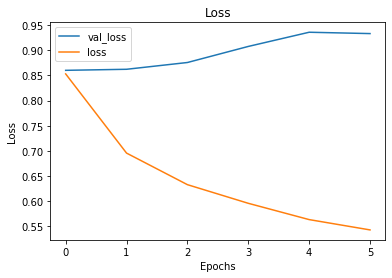

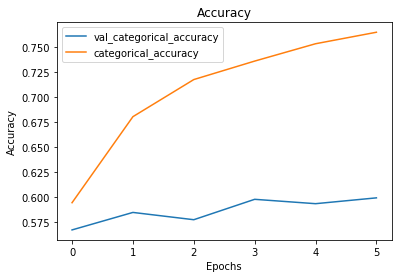

In [36]:
visualize_training_results(emb_model_results)

# Load Saved Model

In [37]:
saved_model = load_model(MODEL_FILE_PATH+MODEL_FILE_NAME)

# Evaluate Model on Test Data

In [38]:
y_hat = saved_model.predict(X_test_seq_pad)

In [39]:
results = saved_model.evaluate(X_test_seq_pad, y_test_oh)

1714/1714 [==============================] - 0s 57us/step


In [40]:
results

[0.8985632987673391, 0.627771295146319]

In [41]:
print(f'Test Accuracy = {round(results[1], 4)}')

Test Accuracy = 0.6278


In [42]:
print(classification_report(y_test_enc, np.argmax(y_hat, axis=1), target_names=le.classes_))

                                    precision    recall  f1-score   support

                  Negative emotion       0.24      0.10      0.14       109
No emotion toward brand or product       0.68      0.80      0.73      1031
                  Positive emotion       0.53      0.42      0.47       574

                          accuracy                           0.63      1714
                         macro avg       0.48      0.44      0.45      1714
                      weighted avg       0.60      0.63      0.61      1714



In [43]:
cm = confusion_matrix(y_test_enc, np.argmax(y_hat, axis=1))

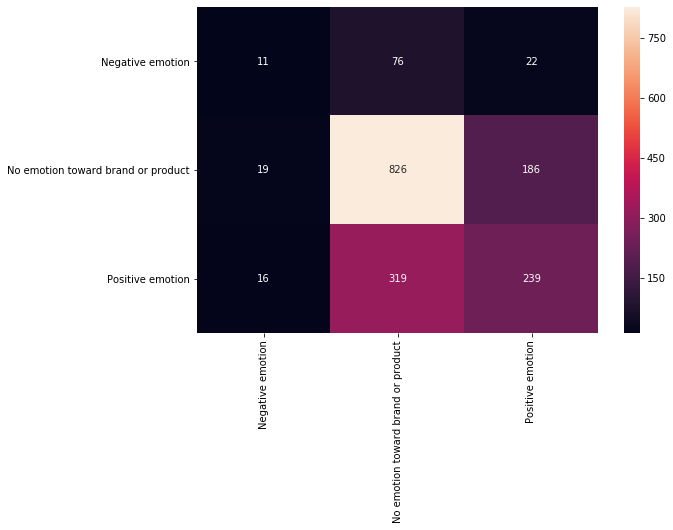

In [44]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(cm, 
            annot=True, 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            fmt='d',
            ax=ax)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

# Summary

This model again does worse than the baseline word embedding model emb_model_01

Using lemmatization made the model do worse on the minority classes.